<a href="https://colab.research.google.com/github/alviyandriadillah/Machine-Learning/blob/main/4_4_Model_Selection%2C_Underfitting%2C_and_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mxnet

In [2]:
pip install d2l

**4.4.4. Polynomial Regression**

In [3]:
import math
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

**4.4.4.1. Generating the Dataset**

In [4]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [5]:
features[:2], poly_features[:2, :], labels[:2]

(array([[-0.03716067],
        [-1.1468065 ]]),
 array([[ 1.0000000e+00, -3.7160669e-02,  6.9045764e-04, -8.5526226e-06,
          7.9455290e-08, -5.9052235e-10,  3.6573678e-12, -1.9415747e-14,
          9.0187767e-17, -3.7238198e-19,  1.3837963e-21, -4.6747996e-24,
          1.4476556e-26, -4.1381425e-29,  1.0984010e-31, -2.7211542e-34,
          6.3199942e-37, -1.3815009e-39,  2.8516424e-42, -5.6051939e-45],
        [ 1.0000000e+00, -1.1468065e+00,  6.5758252e-01, -2.5137332e-01,
          7.2069131e-02, -1.6529869e-02,  3.1594271e-03, -5.1760738e-04,
          7.4199430e-05, -9.4547095e-06,  1.0842723e-06, -1.1304095e-07,
          1.0803007e-08, -9.5299690e-10,  7.8064499e-11, -5.9683248e-12,
          4.2778208e-13, -2.8857840e-14,  1.8385754e-15, -1.1097317e-16]]),
 array([ 5.1432443 , -0.06415121]))

**4.4.4.2. Training and Testing the Model**

In [6]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(l.sum(), d2l.size(l))
    return metric[0] / metric[1]

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

**4.4.4.3. Third-Order Polynomial Function Fitting (Normal)**

In [8]:
pip uninstall matplotlib 

Found existing installation: matplotlib 3.3.3
Uninstalling matplotlib-3.3.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.3


In [9]:
pip install matplotlib

     |████████████████████████████████| 11.2 MB 5.1 MB/s 
     |████████████████████████████████| 890 kB 55.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.5.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


weight: [[ 5.01914    1.2219764 -3.4236698  5.571801 ]]


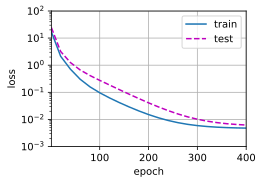

In [10]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

**4.4.4.4. Linear Function Fitting (Underfitting)**

weight: [[2.6986985 4.233507 ]]


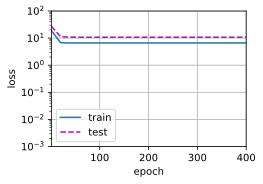

In [11]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

**4.4.4.5. Higher-Order Polynomial Function Fitting (Overfitting)**

weight: [[ 4.9921694   1.3057761  -3.3531585   5.116613   -0.11138638  1.3027492
   0.1268619   0.16640626  0.05132144 -0.02277131  0.00806512 -0.05167991
  -0.02426279 -0.01502216 -0.04941355  0.06389865 -0.04761846 -0.04380166
  -0.05188227  0.05655775]]


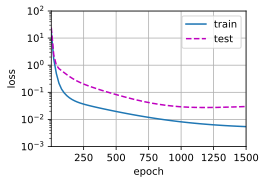

In [12]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)